<a href="https://colab.research.google.com/github/XinminChuUMB/cs480student/blob/main/06/Copy_of_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

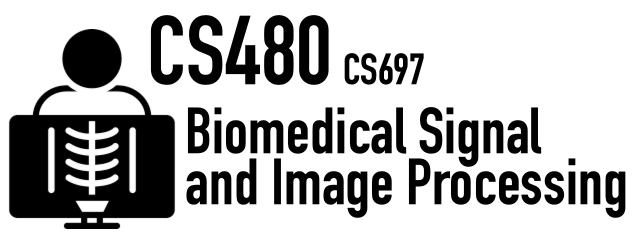
#Assignment 6

Xinmin Chu

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [6]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-wg5xnk4d
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-wg5xnk4d


In [5]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import unet
from unet import utils
from unet.datasets import circles

In [ ]:
unet_model = unet.build_model(channels=circles.channels,
                              num_classes=circles.classes,
                              layer_depth=3,
                              filters_root=16)
unet.finalize_model(unet_model)

In [ ]:
train_dataset, validation_dataset = circles.load_data(100, nx=200, ny=200, splits=(0.7, 0.3))

In [ ]:
import tensorflow as tf

In [ ]:
tf.print(train_dataset)

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 200, 1), dtype=tf.float64, name=None), TensorSpec(shape=(200, 200, 2), dtype=tf.float64, name=None))>


In [ ]:
tf.print(validation_dataset)

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 200, 1), dtype=tf.float64, name=None), TensorSpec(shape=(200, 200, 2), dtype=tf.float64, name=None))>


In [ ]:
next(train_dataset.batch(1).as_numpy_iterator())[1]

In [ ]:
print(len([e for e in train_dataset]))
print(len([e for e in validation_dataset]))

70
30


In [ ]:
trainer = unet.Trainer(checkpoint_callback=False)
trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=5,
            batch_size=1)

Epoch 1/5
70/70 [==============================] - 6s 28ms/step - loss: 0.3612 - categorical_crossentropy: 0.3612 - categorical_accuracy: 0.9240 - mean_iou: 0.4101 - dice_coefficient: 0.7926 - auc: 0.9401 - val_loss: 0.2180 - val_categorical_crossentropy: 0.2180 - val_categorical_accuracy: 0.9532 - val_mean_iou: 0.4440 - val_dice_coefficient: 0.8217 - val_auc: 0.9943 - learning_rate: 0.0010
Epoch 2/5
70/70 [==============================] - 2s 22ms/step - loss: 0.1331 - categorical_crossentropy: 0.1331 - categorical_accuracy: 0.9504 - mean_iou: 0.5559 - dice_coefficient: 0.9276 - auc: 0.9882 - val_loss: 0.0951 - val_categorical_crossentropy: 0.0951 - val_categorical_accuracy: 0.9532 - val_mean_iou: 0.6010 - val_dice_coefficient: 0.9590 - val_auc: 0.9941 - learning_rate: 0.0010
Epoch 3/5
70/70 [==============================] - 1s 21ms/step - loss: 0.1147 - categorical_crossentropy: 0.1147 - categorical_accuracy: 0.9651 - mean_iou: 0.5964 - dice_coefficient: 0.9387 - auc: 0.9906 - val_l

In [ ]:
prediction = unet_model.predict(validation_dataset.batch(batch_size=3))

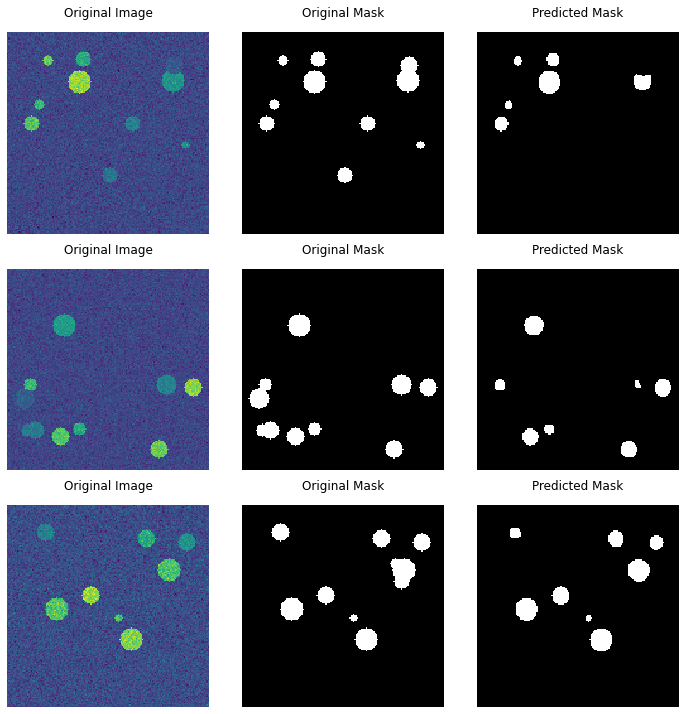

In [ ]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
from typing import Tuple, List

import numpy as np
import tensorflow as tf

channels = 1
classes = 2


def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, nx:int, ny:int, **kwargs) -> Tuple[np.array, np.array]:
    images = np.empty((sample_count, nx, ny, 1))
    labels = np.empty((sample_count, nx, ny, 2))
    for i in range(sample_count):
        image, mask = _create_image_and_mask(nx, ny, **kwargs)
        images[i] = image
        labels[i, ..., 0] = ~mask
        labels[i, ..., 1] = mask
    return images, labels


def _create_image_and_mask(nx, ny, cnt=10, r_min=3, r_max=10, border=32, sigma=20):
    image = np.ones((nx, ny, 1))
    mask = np.zeros((nx, ny), dtype=np.bool)

    for _ in range(cnt):
        a = np.random.randint(border, nx - border)
        b = np.random.randint(border, ny - border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1, 255)

        y, x = np.ogrid[-a:nx - a, -b:ny - b]
        m = x * x + y * y <= r * r
        mask = np.logical_or(mask, m)

        image[m] = h

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    return image, mask

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER

The U-net architecture is synonymous with an encoder-decoder architecture. Essentially, it is a deep-learning framework based on FCNs (Fully Convolutional Networks); it comprises two parts: (1) A contracting path similar to an encoder, to capture context via a compact feature map. (2) A symmetric expanding path similar to a decoder, which allows precise localisation. This step is done to retain boundary information (spatial information) despite down sampling and max-pooling performed in the encoder stage. (Reference: Sukiriti Paul, "Learn How to Train U-Net On Your Dataset", https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623#:~:text=The%20U%2Dnet%20architecture%20is,via%20a%20compact%20feature%20map.)

The U-Net can be trained to conduct classification, segmatation, labelling, annotation on images.

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

"Channels" is the pixel value in the image. Here is one number for a pixel.

"Classes" is the number preset for how many classes the U-Net will target. Here are two classes the images will be classified, background (bg) and foreground (fg).

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

Mitochondria have a distinctive appearance when viewed by electron microscopy. They often appear as rounded or sausage-shaped structures, measuring about 0.5-1.0 µm in diameter and 2-8 µm in length. (Reference: https://www.open.edu/openlearn/science-maths-technology/science/tour-the-cell/content-section-410#:~:text=Mitochondria%20have%20a%20distinctive%20appearance,often%20much%20bigger%20in%20plants.)

In the image, their appearance would be like circle or sausage, so the data will have large values closing to the center (255 = white) and smaller values near the boundaries (0 = dark).

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [15]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE
        #image = image /255.0
        image = tf.cast(image,tf.float32)/255.0

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            image = tf.image.flip_left_right(image)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            image = tf.image.flip_up_down(image)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            image = tf.image.rot90(image)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [16]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the bu

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

There might have 660 * 0.7 = 462 images that being used for training.

In [10]:
print(len([e for e in train]))
print(len([e for e in val]))
print(len([e for e in test]))

461
132
66


In [17]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [18]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [ ]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val,
            epochs=50,
            batch_size=10)

The result from last line:

Frist round:

47/47 - 34s 733ms/step - loss: 0.3017 - categorical_crossentropy: 0.3017 - categorical_accuracy: 0.9115 - mean_iou: 0.4414 - dice_coefficient: 0.8362 - auc_1: 0.9202 - learning_rate: 1.1121e-05 - val_loss: 0.2266 - val_categorical_crossentropy: 0.2266 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4469 - val_dice_coefficient: 0.8552 - val_auc_1: 0.9503

Second round:

47/47 - 68s 1s/step - loss: 0.3022 - categorical_crossentropy: 0.3022 - categorical_accuracy: 0.9115 - mean_iou: 0.4409 - dice_coefficient: 0.8363 - auc: 0.9189 - learning_rate: 1.1121e-05 - val_loss: 0.2283 - val_categorical_crossentropy: 0.2283 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4451 - val_dice_coefficient: 0.8523 - val_auc: 0.9503


**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

<TakeDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(256, 256, 2), dtype=tf.float64, name=None))>

In [ ]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))

for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER

To get the highest predicted values from the one dimension output labels.

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

The quality of the segmentation is not good from my results, with some noises. Except increasing the training data size, we might consider add some convolution layers to the model, or more batches, or set an appropriate learning rate, to improve the prediction accuracy.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TODO: YOUR CODE

In [ ]:
unet_model.summary()

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [ ]:
# TODO: YOUR ANSWER

There are 1,178,480 for encoder and 780,053 parameters for decoder in Casser and collegues' research.

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

They reduce the number of convolutional filters throughout the network, then using more specific trained functions to replace the transpose convolutions.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

To get higher accuracy and faster processing speed.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#